# Introduction

.. index:: Equations; Laplace

## A Laplace problem

As an introduction we will solve
\begin{equation}
-\triangle u + u = f
\end{equation}
in $\Omega=[0,1]^2$, where $f=f(x)$ is a given forcing term.
On the boundary we prescribe Neumann boundary
$\nabla u\cdot n = 0$.

We will solve this problem in variational form
$a(u,v) = l(v)$ with
\begin{equation}
a(u,v) := \int_\Omega \nabla u\cdot\nabla v + uv~,\qquad
l(v) := \int_\Omega fv~.
\end{equation}
We choose $f=(8\pi^2+1)\cos(2\pi x_1)\cos(2\pi x_2)$
so that the exact solution is
\begin{align*}
u(x) = \cos(2\pi x_1)\cos(2\pi x_2)
\end{align*}

We first need to setup a tessellation of $\Omega$. We use a Cartesian
grid with a 20 cells in each coordinate direction

In [1]:
import numpy as np

from dune.grid import structuredGrid
gridView = structuredGrid([0, 0], [1, 1], [20, 20])


.. note::
   In the following we will often use the term ``gridView`` instead of grid.
   The details of what a ``gridView`` is together with some other central
   concepts is provided in the [next section](concepts_nb.ipynb).

.. tip:: An overview of available approaches to construct a grid can be
   found [here](othergrids_nb.ipynb).


Next we define a linear Lagrange Finite-Element space over that grid
and setup a discrete function which we will store the discrete solution
to our PDE

In [2]:
from dune.fem.space import lagrange
space = lagrange(gridView, order=1)
u_h   = space.interpolate(0, name='u_h')

We define the mathematical problem using ufl

In [3]:
from ufl import (TestFunction, TrialFunction, SpatialCoordinate,
                 dx, grad, inner, dot, sin, cos, pi )
x = SpatialCoordinate(space)
u = TrialFunction(space)
v = TestFunction(space)

f = (8*pi**2+1) * cos(2*pi*x[0])*cos(2*pi*x[1])
a = ( inner(grad(u),grad(v)) + u*v ) * dx
l = f*v * dx

Now we can assemble the matrix and the right hand side

In [4]:
from dune.fem import assemble
mat,rhs = assemble(a==l)

We solve the resulting linear system of equations $Ay=b$ using scipy.
To this end it is straightforward to expose the underlying data
structures of ``mat,rhs`` and ``u_h`` using the ``as_numpy`` attribute.

In [5]:
from scipy.sparse.linalg import spsolve as solver

A = mat.as_numpy
b = rhs.as_numpy
y = u_h.as_numpy
y[:] = solver(A,b)

Note the ``y[:]`` which guarantees that the result from the solver is
stored in the same buffer used for the discrete function. Consequently,
no copying is required.

.. tip:: More details on how to use [Scipy](solversExternal_nb.ipynb#Using-Scipy) will be given later
   in the tutorial. Other linear solver backends are also available,
   e.g., [PETSc](solversInternal_nb.ipynb#Other-internal-solvers-(petsc))
   and [PETSc4py can also be used](solversExternal_nb.ipynb#Using-PETSc4Py).

That's it - to see the result we plot it using matplotlib

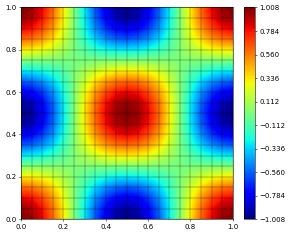

In [6]:
u_h.plot()

Since in this case the exact solution is known,
we can also compute the $L^2$ and $H^1$ errors to see how good our
approximation actually is

In [7]:
from dune.fem import integrate
exact = cos(2*pi*x[0])*cos(2*pi*x[1])
e_h = u_h-exact
squaredErrors = integrate([e_h**2,inner(grad(e_h),grad(e_h))])
print("L^2 and H^1 errors:",[np.sqrt(e) for e in squaredErrors])

L^2 and H^1 errors: [np.float64(0.0048167499302634335), np.float64(0.4025999518395462)]



.. index::
   pair: assemble function ; dune.fem

.. index::
   pair: integrate function ; dune.fem

.. note::
   The ``assemble`` function can be used to assemble bilinear forms as shown
   above, linear forms (functionals) as shown further down, and to compute scalar integrals.
   So we could compute the $L^2$ error using ``assemble(e_h**2*dx)``. We use the
   ``integrate`` function above since it allows to integrate vector valued
   expressions which is more efficient than calling ``assemble`` multiple times.
   Using the assemble function with 'a==l' and 'a-l==0' produces the same result.



.. _label-on-gridview-detection:

.. tip::
   Both ``assemble`` and ``integrate`` take extra arguments ``gridView``
   and ``order``. The latter allows to fix the order of the quadrature used
   to integrate a function - if it is not provided (``None``) a reasonable
   order is determined heuristically.  The ``gridView`` argument is required in
   cases where the ``gridView`` can not be determined from
   the ufl expression.

In the above example ``gridView`` can be extracted from
the discrete function ``u_h`` which is part of the expression for
``e_h``. Consider instead the following example where the ``gridView``
has to be provided to the integrate method


In [8]:
print("average:",integrate(exact,gridView=gridView) )
# since the integrand is scalar, the following is equivalent:
print("average:",assemble(exact*dx,gridView=gridView) )

average: 1.5720931501039814e-17
average: 1.4242011975133806e-17


.. index:: Equations; Boundary value problem

## Laplace equation with Dirichlet boundary conditions
We consider the scalar boundary value problem
\begin{align*}
-\triangle u &= f & \text{in}\;\Omega:=(0,1)^2 \\
\nabla u\cdot n &= g_N & \text{on}\;\Gamma_N \\
u &= g_D & \text{on}\;\Gamma_D
\end{align*}
and $f=f(x)$ is some forcing term.
For the boundary conditions we set $\Gamma_D=\{0\}\times[0,1]$ and take
$\Gamma_N$ to be the remaining boundary of $\Omega$.

We will solve this problem in variational form
\begin{align*}
\int \nabla u \cdot \nabla \varphi \
- \int_{\Omega} f(x) \varphi\ dx
- \int_{\Gamma_N} g_N(x) v\ ds
= 0.
\end{align*}

We choose $f,g_N,g_D$ so that the exact solution is
\begin{align*}
u(x) = \left(\frac{1}{2}(x_1^2 + x_2^2) - \frac{1}{3}(x_1^3 - x_2^3)\right) + 1~.
\end{align*}

.. tip:: More [general boundary conditions](boundary_nb.ipynb) are discussed in a later section.

The setup of the model using ufl is very similar to the previous example
but we need to include the non trivial Neumann boundary conditions:

In [9]:
from ufl import conditional, FacetNormal, ds, div

exact = 1/2*(x[0]**2+x[1]**2) - 1/3*(x[0]**3 - x[1]**3) + 1
a   = dot(grad(u), grad(v)) * dx
f   = -div( grad(exact) )
g_N = grad(exact)
n   = FacetNormal(space)
l   = f*v*dx + dot(g_N,n)*conditional(x[0]>=1e-8,1,0)*v*ds

With the model described as a ufl form, we can again assemble the system
matrix and right hand side using ``dune.fem.assemble``. To take the
Dirichlet boundary conditions into account we construct an instance of
``dune.ufl.DirichletBC`` that described the values to use and the part
of the boundary to apply them to. This is then passed into the
``assemble`` function:

In [10]:
from dune.ufl import DirichletBC
dbc = DirichletBC(space,exact,x[0]<=1e-8)
mat,rhs = assemble([a==l,dbc])

Solving the linear system of equations, plotting the solution, and
computing the error is now identical to the previous example:

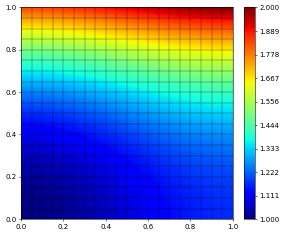

L^2 and H^1 errors: [np.float64(0.0004929227968165433), np.float64(0.031176023550870718)]


In [11]:
u_h.as_numpy[:] = solver(mat.as_numpy, rhs.as_numpy)
u_h.plot()
e_h = u_h-exact
squaredErrors = integrate([e_h**2,inner(grad(e_h),grad(e_h))])
print("L^2 and H^1 errors:",[np.sqrt(e) for e in squaredErrors])

It is straightforward to solve a problem with a different right hand side
and different boundary values. Assuming the type of the boundary
conditions remains the same, the system matrix does not change we
only need to reassemble the right hand side:

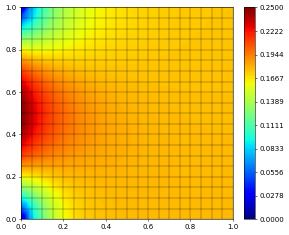

In [12]:
l   = conditional(dot(x,x)<0.1,1,0)*v*dx
dbc = DirichletBC(space,x[1]*(1-x[1]),x[0]<=1e-8)
rhs = assemble([l,dbc])
u_h.as_numpy[:] = solver(mat.as_numpy, rhs.as_numpy)
u_h.plot()

## A non-linear elliptic problem
.. index:: Equations; Non-linear elliptic

It is very easy to solve a non-linear elliptic problem with very few
changes to the above code.
We will demonstrate this using the PDE
\begin{equation}
-\triangle u + m(u) = f
\end{equation}
in $\Omega=[0,1]^2$, where again $f=f(x)$ is a given forcing term
and $m=m(u)$ is some non-linearity.
On the boundary we still prescribe Neumann boundary
$\nabla u\cdot n = 0$.

We will solve this problem in variational form
\begin{equation}
\int_\Omega \nabla u\cdot\nabla v + m(u)v = \int_\Omega fv~.
\end{equation}
We use $f(x)=|x|^2$ as forcing and choose $m(u) = (1+u)^2u$.
Most of the code is identical to the linear case, we can use the same
grid, discrete lagrange space, and the discrete function ``u_h``.
The model description using ufl is also very similar

In [13]:
a = ( inner(grad(u),grad(v)) + (1+u)**2*u*v ) * dx
l = dot(x,x)*v * dx

To solve the non-linear problem we need to use something like a Newton
solver. We could use
[the implementation available in Scipy](solversExternal_nb.ipynb)
but ``dune-fem`` provides so called
[schemes](concepts_nb.ipynb#Operators-and-Schemes)
that have a ``solve`` method which can handle both linear and non-linear models.

.. note:: The default solver is based on a Newton-Krylov solver using a
   ``gmres`` method to solve the intermediate linear problems.

Since the problem we are considering is symmetric we can use a ``cg`` method which we
do during construction of the scheme:

In [14]:
from dune.fem.scheme import galerkin as solutionScheme
scheme = solutionScheme(a == l, solver='cg')
u_h.clear() # set u_h to zero as initial guess for the Newton solver
info = scheme.solve(target=u_h)

.. tip:: These ``schemes`` provide options for solving PDEs
   for writing your own solvers, accessing
   degrees of freedom on the boundary etc. A description of the
   API is given [here](scheme_api.rst) and example usage is
   available in the sections on the use of
   [internal solvers](solversInternal_nb.ipynb) and
   [external solvers](solversExternal_nb.ipynb).
   A list of solvers, preconditioners, and parameters is available
   [here](solversInternal_nb.ipynb#Available-solvers-and-parameters).

That's it - we can plot the solution again - we don't know the exact
solution so we can't compute any errors in this case.
In addition the ``info`` structure returned by the ``solve`` method
gives some information on the solver like number of iterations required

{'converged': True, 'iterations': 5, 'linear_iterations': 250, 'timing': [0.01147905, 0.002313059, 0.009165990999999998]}


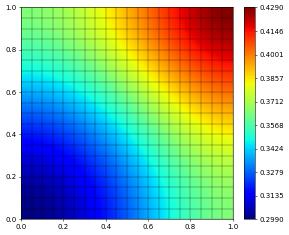

In [15]:
print(info)
u_h.plot()

Let's complete this discussion by looking at the experimental order of
convergence (EOC) of our approximation. For this we add a forcing that
leads to the problem having the prescribed solution
\begin{align*}
u(x,y) = \left(\frac{1}{2}(x^2 + y^2) - \frac{1}{3}(x^3 - y^3)\right) + 1
\end{align*}

step: 0 , size: 400
		 L^2, H^1 error: 2.16373e-04, 3.11774e-02 , eocs = ['-', '-']
		 solver info= {'converged': True, 'iterations': 8, 'linear_iterations': 433, 'timing': [0.014043957, 0.003968186, 0.010075770999999999]}


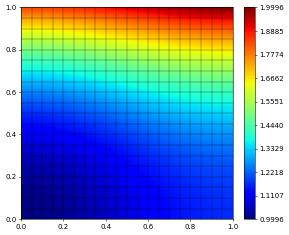

step: 1 , size: 1600
		 L^2, H^1 error: 5.40907e-05, 1.55899e-02 , eocs = [np.float64(2.0), np.float64(1.0)]
		 solver info= {'converged': True, 'iterations': 8, 'linear_iterations': 789, 'timing': [0.050317823, 0.012393448000000001, 0.037924374999999996]}


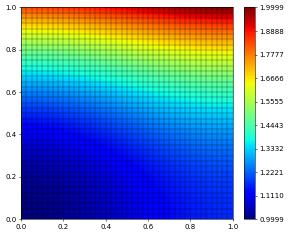

In [16]:
exact = 1/2*(x[0]**2+x[1]**2) - 1/3*(x[0]**3 - x[1]**3) + 1
a  = ( inner(grad(u),grad(v)) + (1+u)**2*u*v ) * dx
bf = (-div(grad(exact)) + (1+exact)**2*exact) * v * dx
bg = dot(grad(exact),n)*v*ds
scheme = solutionScheme(a == bf+bg, solver="cg")

errors = 0,0
loops = 2
for eocLoop in range(loops):
    u_h.interpolate(0)
    info = scheme.solve(target=u_h)
    errors_old = errors
    l2error, h1error = dot(u_h-exact, u_h-exact), dot(grad(u_h-exact), grad(u_h-exact))
    errors = [np.sqrt(e) for e in integrate([l2error,h1error])]
    if eocLoop == 0:
        eocs = ['-','-']
    else:
        eocs = [ round(np.log(e/e_old)/np.log(0.5),2) for e,e_old in zip(errors,errors_old) ]
    print("step:", eocLoop, ", size:", gridView.size(0))
    print("\t\t L^2, H^1 error:",'{:0.5e}, {:0.5e}'.format(*errors),", eocs =", eocs)
    print("\t\t solver info=",info)
    u_h.plot()
    if eocLoop < loops-1:
        gridView.hierarchicalGrid.globalRefine(1)

.. index::
   pair: Models; Constants

## Using `Constant` parameters and grid functions in PDEs

Every time we call `assemble` or construct a new `scheme` as show above,
some code must be compiled which leads to some extra cost. In time
critical points of the simulation, e.g., in loops, this extra cost is not
acceptable. To avoid recompilation general
[grid functions](concepts_nb.ipynb#Grid-Functions)
and placeholders for scalar or vector valued
[constants](concepts_nb.ipynb#Operators-and-Schemes)
can be used within the ufl forms.
In the [next section](concepts_nb.ipynb) we will give a full example for this in the
context of a time dependent problems.

As a simple introduction we consider a linear version of the elliptic problem
considered previously
$$ -\varepsilon \triangle u(x) + m(x) u(x) = f(x) $$
with Neuman boundary conditions.
We also added a real valued constant $\varepsilon$ and we want to able to
change $m$ easily. Assuming $\bar{u}$ is the exact solution of the
non-linear elliptic problem from above then $\bar{u}$ will also solve the
above equation if $\varepsilon=1$ and we chose
$m(x) = (1+\bar{u})^2$. We will use the discrete solution $u_h$
from above, which is an approximation to $\bar{u}$ and chose
$m(x) = (1+u_h)^2$. Later we want to solve
the same linear problem but with $\varepsilon=0$ and $m(x)=1$
so that we are simply looking at the $L^2$ projection of $f$:
$$ \int_\Omega uv = \int_\Omega fv~. $$

Although the problem is linear and we could just use
``dune.fem.assemble`` and Scipy to solve it, we will again use a ``scheme`` instead.
Details on schemes and operators will be provided in the following
section. For this example the important characteristic of a `scheme` is
that we can still access some information contained in the underlying UFL
form, e.g., the `Constants` used. This allows us to change these
efficiently during the simulation as shown below.

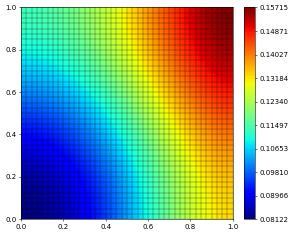

In [17]:
from dune.ufl import Constant

epsilon = Constant(1,name="eps")   # start with epsilon=1
x,u,v   = SpatialCoordinate(space), TrialFunction(space), TestFunction(space)
f       = dot(x,x)
a       = epsilon*dot(grad(u), grad(v)) * dx + (1+u_h)**2*u*v * dx
b       = f*v*dx

scheme = solutionScheme(a == b, solver='cg')
w_h    = space.interpolate(0,name="w_h")
scheme.solve(target = w_h)
w_h.plot()

from dune.fem.operator import galerkin
op = galerkin(a == b)


Note that since $\varepsilon=1$ and we use the previously computed approximation $u_h$
the new discrete function $w_h$ is close to $u_h$.

We can print the value of a `Constant` with name `foo` either via
`scheme.model.foo` or using the `value` on the `Constant` itself.
We can change the value using the same attribute. See the discussion at
the end of section on operators and schemes in the [concepts chapter](concepts_nb.ipynb#Operators-and-Schemes) for
more detail on these two approaches.

In [18]:
print(scheme.model.eps, epsilon.value)
epsilon.value = 0                          # change to the problem which matches our exact solution
print(scheme.model.eps, epsilon.value)

1.0 1.0
0.0 0.0


To switch to a standard $L^2$ projection we will also change
$m=(1+u_h)^2$ to $m\equiv 1$. This can be easily done by changing $u_h$
to be zero everywhere. This can be either done using `u_h.interpolate(0)` or
by using `u_h.clear()`.

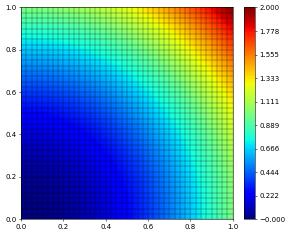

In [19]:
u_h.interpolate(0)
scheme.solve(target = w_h)
w_h.plot()

.. tip:: A wide range of problems a covered in the
   [further examples](furtherexamples.rst) section.
   In the [next section](concepts_nb.ipynb) we explain the main concepts
   we use to solve PDE using finite-element approximations which we end with
   a solution to a non-linear time-dependent problem using the
   Crank-Nicolson method in time.